In [29]:
import GEOparse
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
gse = GEOparse.get_GEO(filepath="GSE113865_family.soft")
gpl = gse.gpls["GPL10558"]

30-May-2025 13:58:19 INFO GEOparse - Parsing GSE113865_family.soft: 
30-May-2025 13:58:19 DEBUG GEOparse - DATABASE: GeoMiame
30-May-2025 13:58:19 DEBUG GEOparse - SERIES: GSE113865
30-May-2025 13:58:19 DEBUG GEOparse - PLATFORM: GPL10558
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121915
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121916
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121917
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121918
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121919
30-May-2025 13:58:22 DEBUG GEOparse - SAMPLE: GSM3121920


In [10]:
print(gpl.table.columns)
print(gse.metadata)
print(gse.phenotype_data.head())

Index(['ID', 'Species', 'Source', 'Search_Key', 'Transcript', 'ILMN_Gene',
       'Source_Reference_ID', 'RefSeq_ID', 'Unigene_ID', 'Entrez_Gene_ID',
       'GI', 'Accession', 'Symbol', 'Protein_Product', 'Probe_Id',
       'Array_Address_Id', 'Probe_Type', 'Probe_Start', 'SEQUENCE',
       'Chromosome', 'Probe_Chr_Orientation', 'Probe_Coordinates', 'Cytoband',
       'Definition', 'Ontology_Component', 'Ontology_Process',
       'Ontology_Function', 'Synonyms', 'Obsolete_Probe_Id', 'GB_ACC'],
      dtype='object')
{'title': ['Genome-wide gene expression analysis of triple negative breast cancer tissue and matched normal tissue'], 'geo_accession': ['GSE113865'], 'status': ['Public on Apr 30 2023'], 'submission_date': ['Apr 30 2018'], 'last_update_date': ['May 01 2023'], 'summary': ['To identify specifically gene expression level in only TNBC subtype, we analyed mRNA microarray in 3 TNBC samples and matched normal samples.'], 'overall_design': ['3 TNBC vs. 3 normal breast tissue samples

In [37]:
gpl_obj = gse.gpls["GPL10558"]

expression_data = gse.pivot_and_annotate(
    values="VALUE",
    gpl=gpl_obj,
    annotation_column="ILMN_Gene"
)

expression_data = expression_data.dropna()
print(expression_data.head())


name          GSM3121915  GSM3121916  GSM3121917  GSM3121918  GSM3121919  \
ID_REF                                                                     
ILMN_1343291   15.685781   15.793626   15.361298   15.764970   15.780587   
ILMN_1343295   12.715918   13.452997   12.571926   12.615727   12.488269   
ILMN_1651199    6.696416    6.683945    6.554789    6.681061    6.679294   
ILMN_1651209    6.906228    7.121419    6.931258    7.042967    7.173161   
ILMN_1651210    6.530276    6.634925    6.482379    6.742938    6.666924   

name          GSM3121920  ILMN_Gene  
ID_REF                               
ILMN_1343291   15.764970     EEF1A1  
ILMN_1343295   13.306856      GAPDH  
ILMN_1651199    6.270460  LOC643334  
ILMN_1651209    7.001429    SLC35E2  
ILMN_1651210    6.609283     DUSP22  


In [22]:
# Sample to group mapping based on metadata
tnbc_samples = []
normal_samples = []

for gsm_name, gsm_obj in gse.gsms.items():
    desc = gsm_obj.metadata.get("source_name_ch1", [""])[0].lower()
    if "cancer tissue" in desc:
        tnbc_samples.append(gsm_name)
    elif "adjacent tissue" in desc:
        normal_samples.append(gsm_name)

print("TNBC samples:", tnbc_samples)
print("Normal samples:", normal_samples)


TNBC samples: ['GSM3121916', 'GSM3121918', 'GSM3121920']
Normal samples: ['GSM3121915', 'GSM3121917', 'GSM3121919']


In [24]:
results = pd.DataFrame(index=expression_data.index)
results["logFC"] = (expression_data[tnbc_samples].mean(axis=1) - expression_data[normal_samples].mean(axis=1))
results["pvalue"] = ttest_ind(expression_data[tnbc_samples], expression_data[normal_samples], axis=1).pvalue

In [26]:
#Adjust p-values#
results["adj_pval"] = multipletests(results["pvalue"], method="fdr_bh")[1]

results = results.sort_values("adj_pval")

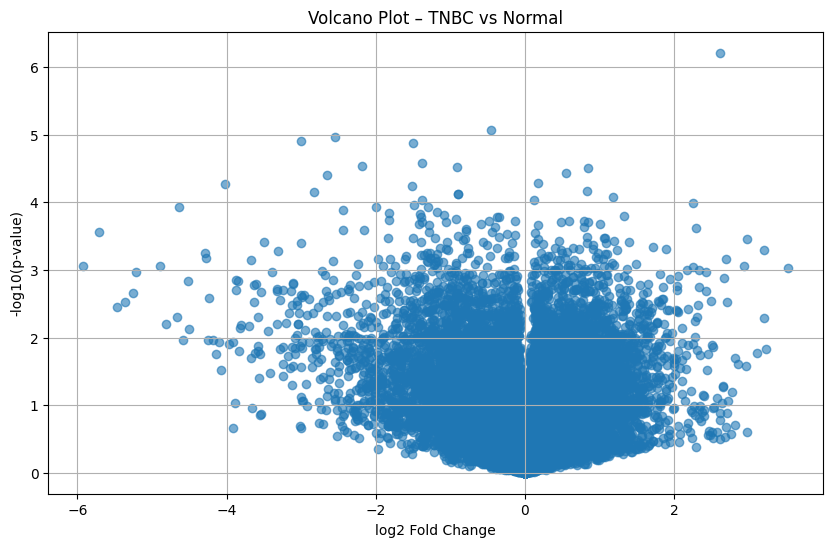

In [28]:
#Volcano Plot#
plt.figure(figsize=(10,6))
plt.scatter(results["logFC"], -np.log10(results["pvalue"]), alpha=0.6)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot – TNBC vs Normal")
plt.grid(True)
plt.show()

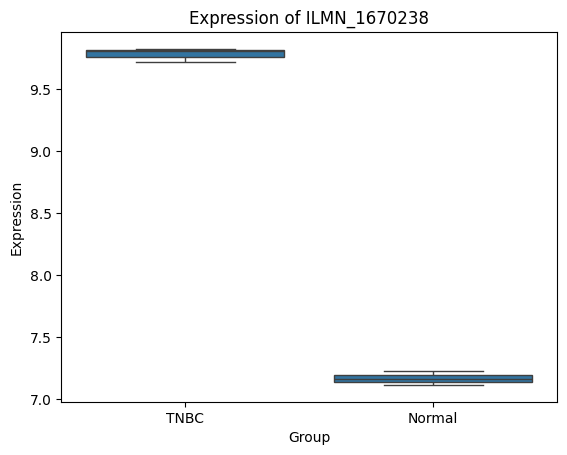

In [31]:
#Boxplot for a Gene (e.g., one with lowest p-value)#
top_gene = results.index[0]
df = pd.DataFrame({
"Expression": list(expression_data.loc[top_gene, tnbc_samples]) + list(expression_data.loc[top_gene, normal_samples]),
"Group": ["TNBC"]*3 + ["Normal"]*3
})
sns.boxplot(data=df, x="Group", y="Expression")
plt.title(f"Expression of {top_gene}")
plt.show()

In [35]:
#Calculate mean, logFC, p-value#
results = pd.DataFrame(index=expression_data.index)
results["logFC"] = expression_data[tnbc_samples].mean(axis=1) - expression_data[normal_samples].mean(axis=1)
results["pvalue"] = ttest_ind(expression_data[tnbc_samples],expression_data[normal_samples], axis=1, equal_var=False).pvalue
results.head()

,logFC,pvalue
ID_REF,,
ILMN_1343291,0.165300,0.322452
ILMN_1343295,0.533156,0.168476
ILMN_1651199,-0.098344,0.555313
ILMN_1651209,0.051723,0.618121
ILMN_1651210,0.102522,0.216305


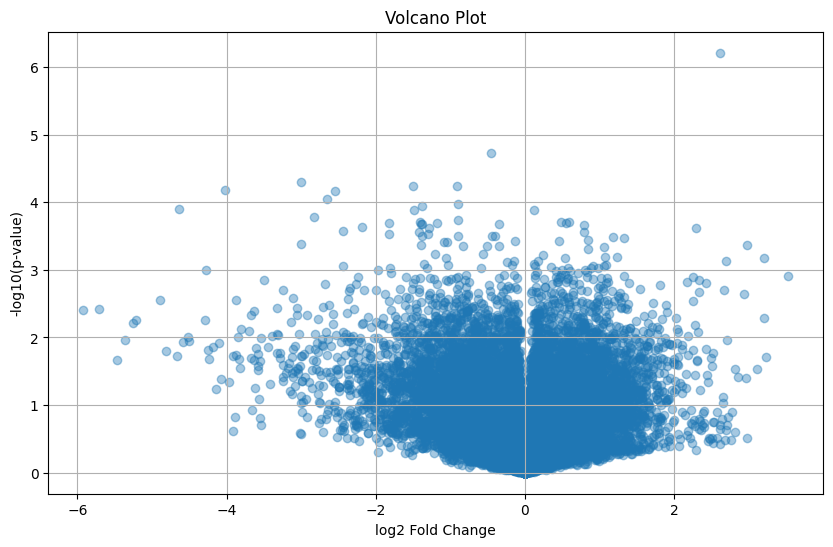

In [38]:
print(gse.gsms.keys())


dict_keys(['GSM3121915', 'GSM3121916', 'GSM3121917', 'GSM3121918', 'GSM3121919', 'GSM3121920'])


In [39]:
print(expression_data.columns)


Index(['GSM3121915', 'GSM3121916', 'GSM3121917', 'GSM3121918', 'GSM3121919',
       'GSM3121920', 'ILMN_Gene'],
      dtype='object', name='name')
